In [1]:
from smart_open import open
import json
import supermercado
import rasterio as rio
import rioxarray
from rioxarray.merge import merge_arrays
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [2]:
import sys
sys.path.insert(1, './../ds_data_generation')

from utils_raster2vector import polygonize_raster, polygonize_raster_exterior, projectShapes
from utils_vegetation import get_ndvi, filter_grassland_shrup,filter_dense_vegetation 
from utils import  save_featurecollection, get_dataArray

    

In [3]:
# geojson_area="https://gist.githubusercontent.com/Rub21/e90a4b4db33746a5be4dc9ac6137c4ed/raw/426864424cc3ab37480f35e0878dbfd59205fe29/ayac.geojson"
geojson_area="fixtures/reforestamos.geojson"
with open(geojson_area, "r", encoding="utf8") as f:
        feature_collection = json.load(f)["features"]
tiles = supermercado.burntiles.burn(feature_collection,14)
tiles

array([[3611, 6987,   14],
       [3612, 6987,   14],
       [3613, 6987,   14],
       [3614, 6987,   14],
       [3611, 6988,   14],
       [3612, 6988,   14],
       [3613, 6988,   14],
       [3614, 6988,   14],
       [3611, 6989,   14],
       [3612, 6989,   14],
       [3613, 6989,   14],
       [3614, 6989,   14]])

In [74]:
mosaic_ids = [
    # {"date":"2020-03_2020-06","name": "2020_spring", "mosaic_id":"30b214f3dd229a255b98d47591391e13"},
    # {"date":"2020-06_2020-09","name": "2020_summer", "mosaic_id":"3433c3eb0fb7b7526fcde72de384b4b6"},
    # {"date":"2020-09_2020-12","name": "2020_autumn", "mosaic_id":"35dcb8a0f5b040f81cae393797b4f165"},
    # {"date":"2020-12_2021-03","name": "2021_winter", "mosaic_id":"5c4077562a16cfd5a5f2131a65679094"},
    # {"date":"2021-03_2021-06","name": "2021_spring", "mosaic_id":"217af96b6f5eff81477cf0f155299ec7"},
    # {"date":"2021-06_2021-09","name": "2021_summer", "mosaic_id":"a93bf200ce915812477469fc356dcdda"},
    # {"date":"2021-09_2021-12","name": "2021_autumn", "mosaic_id":"605554a32fb193d8deb861af3b0497a7"},
    # {"date":"2021-12_2022-03","name": "2022_winter", "mosaic_id":"c9aa9a8cd6677a854e1d62a01c748871"},
    {"date":"2022-03_2022-06","name": "2022_spring", "mosaic_id":"039e234ce52b9c99c80fb4d4913a56b5"},
    # {"date":"2022-06_2022-09","name": "2022_summer", "mosaic_id":"01c43f8bcb8dafaedca16ee5f40f5d07"},
    # {"date":"2022-09_2022-12","name": "2022_autumn", "mosaic_id":"9c864f9168ca1e6367b022a09edb2410"},
    # {"date":"2022-12_2023-03","name": "2023_winter", "mosaic_id":"c329dcdf0f41e3115134fb8894932eff"},
]
# tms="https://planetarycomputer.microsoft.com/api/data/v1/mosaic/tiles/{mosaic_id}/{z}/{x}/{y}?scale=2&assets=B04&assets=B03&assets=B02&color_formula=Gamma+RGB+3.2+Saturation+0.8+Sigmoidal+RGB+25+0.35&collection=sentinel-2-l2a"
tms="https://planetarycomputer.microsoft.com/api/data/v1/mosaic/tiles/{mosaic_id}/{z}/{x}/{y}?scale=2&{assets}&collection=sentinel-2-l2a&format=tif"

In [75]:
images={}
objs_arrays = {}
for mosaic in mosaic_ids:
    mosaic_id = mosaic["mosaic_id"]
    name = mosaic["name"]
    date_ = mosaic["date"]
    for tile in tiles:
        x,y,z=tile
        str_tile_name = "-".join( [str(t) for t in tile ])
        assets="assets=B04&assets=B08"
        url = tms.format(mosaic_id=mosaic_id,x=x,y=y,z=z, assets=assets)
        dataArray = get_dataArray(name,url)
        
        if dataArray is not None:
            title =  name
            dArray = get_ndvi(dataArray)
            # dArray_= filter_dense_vegetation(dArray)
            objs_arrays[str_tile_name]=dArray
        
list_values =list(objs_arrays.values())


In [77]:
list_values[0]
# len(list_values)
# objs_arrays.keys()
comp_array = np.stack(list_values)

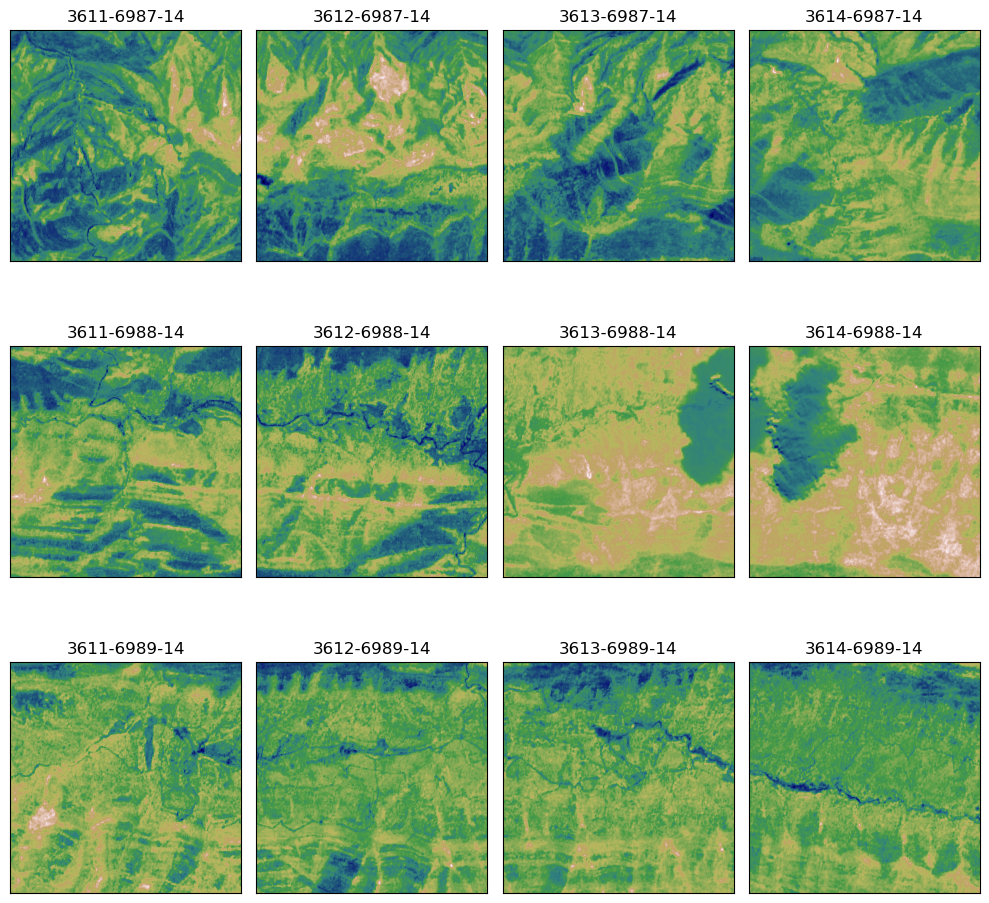

(12, 512, 512)

In [78]:
ep.plot_bands(comp_array, cmap = 'gist_earth', title=list(objs_arrays.keys()), figsize = (10, 10), cols = 4, cbar = False)
comp_array.shape


# Clustering

In [79]:
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [80]:
# # Get geo values from the first raster
sample = list(objs_arrays.values())[0]

bands, height, width  = comp_array.shape

imgxyb = np.empty((height, width, bands), sample.dtype)

# merge layers as bands/values
for index, title in enumerate(layers):
    imgxyb[:,:,index] = objs_arrays[title]

# # conver 1D array
img1d=imgxyb[:,:,:].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))

print(img1d.shape)

img1d[np.isnan(img1d)] = 0


print(img1d.shape)


(262144, 12)
(262144, 12)


In [81]:
cl = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)



/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


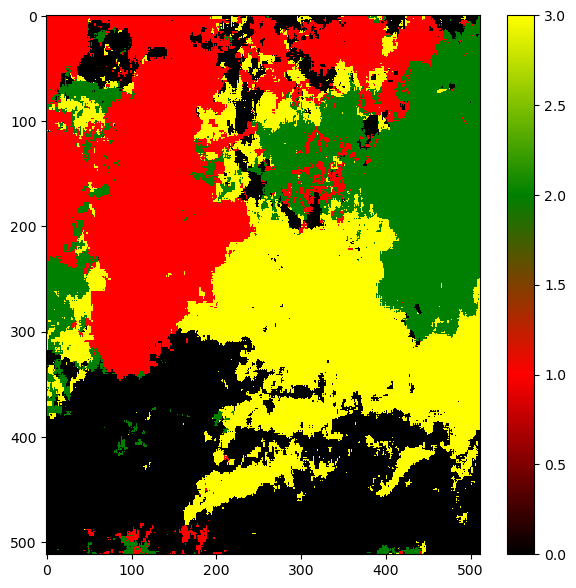

In [82]:
# Create a custom color map to represent our different 4 classes
cmap = LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
plt.figure(figsize = (7,7))
plt.imshow(img_cl, cmap=cmap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()


In [83]:
results_ = sample*0 + img_cl
results_raster = results_.rio.reproject('epsg:3857')
results_raster.rio.to_raster("data/resutls_2.tif")



# Convert Raster to vector

In [84]:
dataset = rio.open("data/resutls_2.tif")
features = polygonize_raster_exterior(dataset)
features_filter = [f for f in features if f["properties"]["v"] !=0.0]
save_featurecollection( features_filter,'data/results.geojson')
# features_filter

/tmp/ipykernel_508/526573745.py:2: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = polygonize_raster_exterior(dataset)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


Save data/results.geojson


In [97]:
# # open the raster image
# elmanagel = rio.open(‘elmanagel.tif’)
# # create an empty array with same dimensions and data type 
# elman_xyb = np.empty((elmanagel.height, elmanagel.width,elmanagel.count), elmanagel.meta['dtype'])
# # loop through the raster bands and fill the empty array in x-y-bands order

for value in list_values:
    height, width  = value.shape
    elman_imgxyb = np.empty((height, width, 1), sample.dtype)
    
    elman_imgxyb[:,:,0] = value
    print(elman_imgxyb.shape)
    elman_1d = elman_imgxyb[:,:,:3].reshape(elman_imgxyb.shape[0]*elman_imgxyb.shape[1], elman_imgxyb.shape[2])
    print(elman_1d.shape)
    

    pred = cl.predict(elman_1d)
    # reshape the 1d array predictions to x-y-bands shape order (only one band)
    elman_cul = pred
    elman_cul = elman_cul.reshape(elman_xyb[:,:,0].shape)
    print(elman_cul.shape)
    

(512, 512, 1)
(262144, 1)


ValueError: X has 1 features, but KMeans is expecting 12 features as input.